# Task 5: Unsupervised analysis

#### Clustering is aimed at identifying natural groups in data. There is a wide variety of unsupervised classification techniques, which, depending on the data set under analysis, partition data differently. The purpose of this theme is to understand the principles behind each clustering method and, therefore, to choose the most appropriate method to be applied in a given context.
#### Most methods require pre-determined number of groups. However, there are also automatic ways of identifying a graphical representation of a numeric index based on the number of groups followed by the elbow or the maximization of a score such as Silhouette-Width.
#### Unsupervised classification methods to work on this theme:
1. Hierarchical algorithms: single link, full link, average link, Ward variance
1. Density based algorithms: DBSCAN or variations
1. The k-Means algorithm
1. Expectation-Maximization (EM) clustering
1. Self-organizing maps (SOM)

#### For each of the datasets here, we will specify which algorithms are best suited to identify natural groups - as they appear to a data view justifying the answer and considering the number of known classes.
-------


#### Imports

In [1]:
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import linalg

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

from sklearn.metrics.cluster import adjusted_rand_score

from neupy import algorithms, utils

from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

#### Functions to plot different types of clustering

In [2]:
def plot_clusters(data, ax):
    sns.scatterplot(
        x='x',
        y='y',
        data=data, 
        hue='class', 
        ax=ax,
        palette=sns.color_palette("muted", n_colors=len(set(data['class'])))
    )


def plot_patches(X, Y_, means, covariances, ax):
    color_iter = itertools.cycle(sns.color_palette("muted", n_colors=len(set(data['class']))))
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        if len(np.where(Y_ == i)[0]) == 0:
            continue
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = Ellipse(mean, v[0], v[1], 180. + angle, color=color, alpha=0.25)
        ell.set_clip_box(ax.bbox)
        ax.add_artist(ell)

def plot_hierarhical_cluster(data, linkage, n_clusters, ax, affinity='euclidean'):
    clustering = AgglomerativeClustering(
        linkage=linkage, 
        n_clusters=n_clusters,
        affinity=affinity
    ).fit_predict(data.iloc[:, 0:2])
    
    clustered_data = data.copy()
    clustered_data['class'] = clustering
    plot_clusters(clustered_data, ax)
    
    adjusted_index = adjusted_rand_score(clustering, data['class'])
    ax.set_title(linkage + " linkage. Adjusted Index: " + str(adjusted_index))

    
def plot_kmeans_cluster(data, n_clusters, ax,  init='k-means++'):
    clustering = KMeans(n_clusters=n_clusters, init=init, random_state=23) \
                                    .fit_predict(data.iloc[:, 0:2])

    clustered_data = data.copy()
    clustered_data['class'] = clustering
    plot_clusters(clustered_data, ax)
    
    adjusted_index = adjusted_rand_score(clustering, data['class'])
    ax.set_title("KMeans. Adjusted Index: " + str(adjusted_index))
    
    
def plot_dbscan_cluster(data, ax, eps=0.5, min_samples=5, metric='euclidean'):
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric) \
                    .fit_predict(data.iloc[:, 0:2])

    clustered_data = data.copy()
    clustered_data['class'] = clustering
    plot_clusters(clustered_data, ax)
    
    adjusted_index = adjusted_rand_score(clustering, data['class'])
    ax.set_title("DBSCAN. Adjusted Index: " + str(adjusted_index))
    
def plot_estimation_maximization_cluster(data, ax, n_clusters, covariance_type="full", max_iter=100, n_init=1):
    em = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, max_iter=max_iter, n_init=n_init)
    em.fit(data.iloc[:, 0:2])
    
    clustering = em.predict(data.iloc[:, 0:2])

    clustered_data = data.copy()
    clustered_data['class'] = clustering
    plot_clusters(clustered_data, ax)
    
    print("EM convergence:" + str(em.converged_))
    
    plot_patches(data.iloc[:, 0:2], clustering, em.means_, em.covariances_, ax)
    
    # display predicted scores by the model as a contour plot
    x = np.linspace(np.min(data['x']), np.max(data['x']))
    y = np.linspace(np.min(data['y']), np.max(data['y']))
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -em.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 100), alpha=0.3)
    
    adjusted_index = adjusted_rand_score(clustering, data['class'])
    ax.set_title("EM. Adjusted Index: " + str(adjusted_index))
    
def plot_bayesian_estimation_maximization_cluster(data, ax, n_clusters, covariance_type="full", max_iter=100, n_init=1):
    em = BayesianGaussianMixture(n_components=n_clusters, covariance_type=covariance_type, max_iter=max_iter, n_init=n_init)
    em.fit(data.iloc[:, 0:2])
    
    clustering = em.predict(data.iloc[:, 0:2])

    clustered_data = data.copy()
    clustered_data['class'] = clustering
    plot_clusters(clustered_data, ax)
    
    print("Bayesian estimation convergence:" + str(em.converged_))
    
    try:
        plot_patches(data.iloc[:, 0:2], clustering, em.means_, em.covariances_, ax)
    except:
        pass
    
    # display predicted scores by the model as a contour plot
    x = np.linspace(np.min(data['x']), np.max(data['x']))
    y = np.linspace(np.min(data['y']), np.max(data['y']))
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -em.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 100), alpha=0.3)
    
    adjusted_index = adjusted_rand_score(clustering, data['class'])
    ax.set_title("Bayesian estimation. Adjusted Index: " + str(adjusted_index))
    
def plot_sofm_cluster(data, n_clusters, ax):
    ggplot_colors = plt.rcParams['axes.prop_cycle']
    colors = np.array([c['color'] for c in ggplot_colors])
    
    data = data.copy()
    
    sofm = algorithms.SOFM(
        # Use only two features for the input
        n_inputs=2,

        # Number of outputs defines number of features
        # in the SOFM or in terms of clustering - number
        # of clusters
        n_outputs=n_clusters,

        # In clustering application we will prefer that
        # clusters will be updated independently from each
        # other. For this reason we set up learning radius
        # equal to zero
        learning_radius=0,

        # Training step size or learning rate
        step=0.25,

        # Shuffles dataset before every training epoch.
        shuffle_data=True,
        
        # Shows training progress in terminal
        verbose=False,
    )
    sofm.train(data.iloc[:, 0:2], epochs=100)
    
    labels = []
    for idx, data_point in data.iterrows():
        a = [data_point['x'], data_point['y']]
        
        distances = []
        for cluster_center in zip(sofm.weight[0], sofm.weight[1]):
            distances.append(distance.euclidean(a, cluster_center))
            
        labels.append(distances.index(min(distances)))
    
    adjusted_index = adjusted_rand_score(labels, data['class'])
    ax.set_title("SOFM clustering. Adjusted Index: " + str(adjusted_index))
    
    data['class'] = labels
    
    plot_clusters(data, ax)

### Smile 

EM convergence:True
Bayesian estimation convergence:True


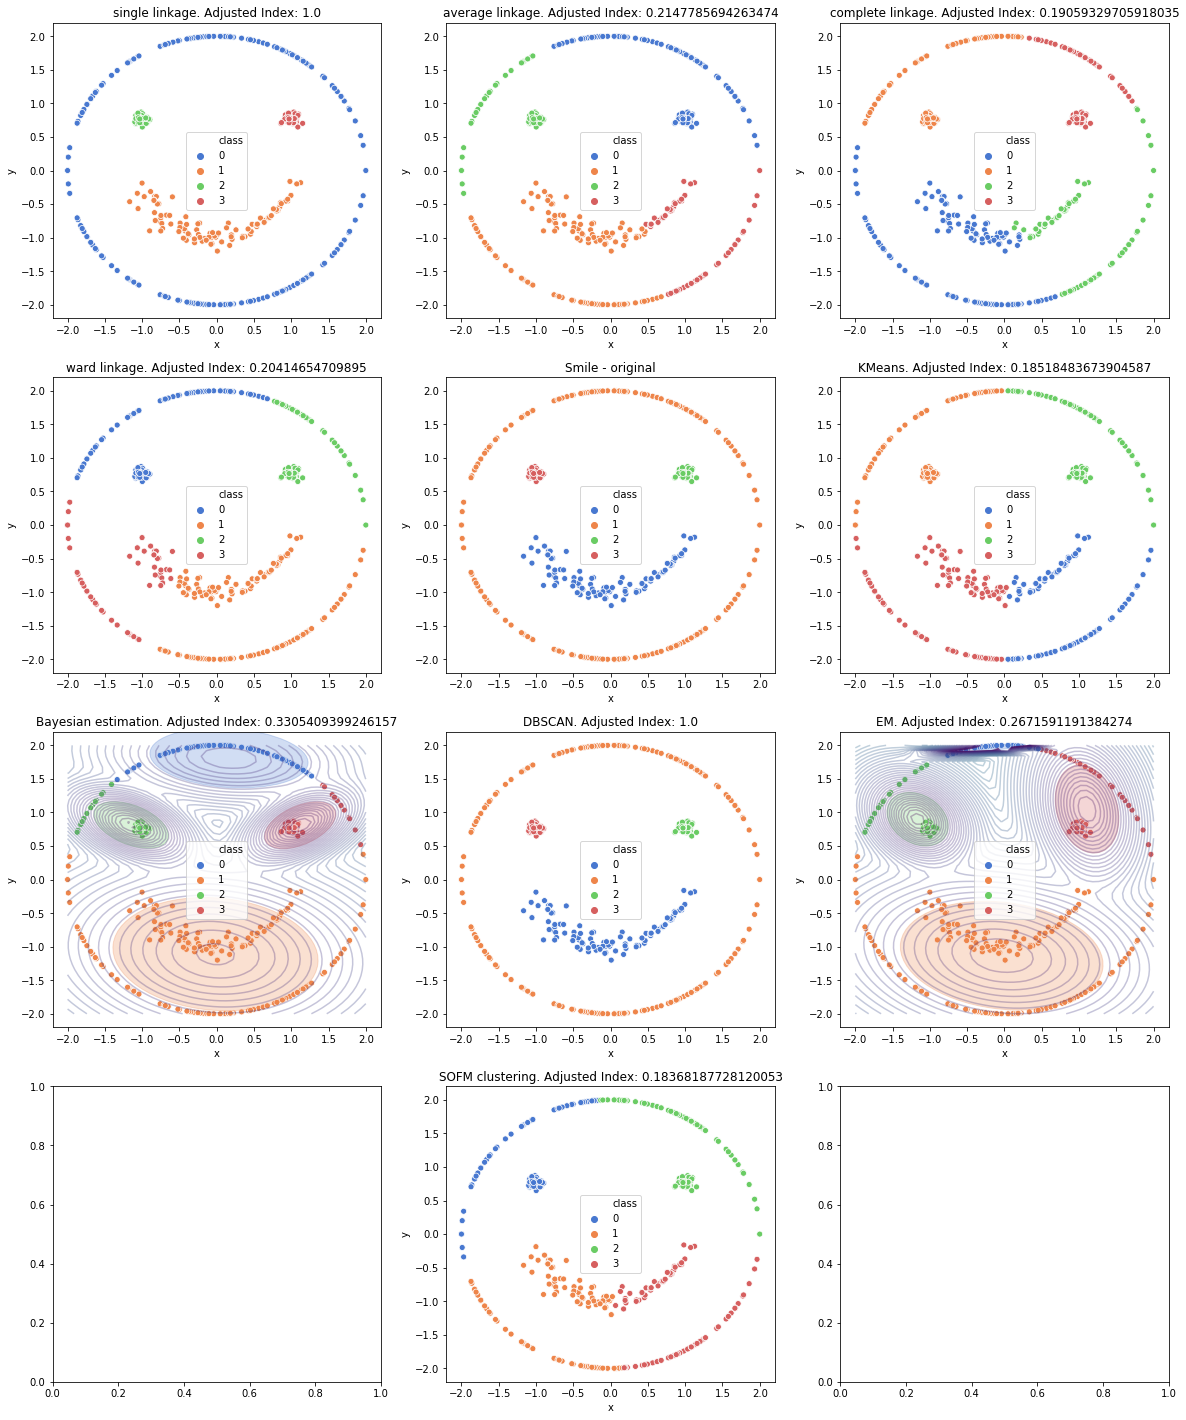

In [3]:
data = pd.read_csv('./data/smile.csv', sep=',', header=None)
data.columns = ['x','y','class']
number_of_classes = len(data['class'].unique())

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 25))
    
plot_clusters(data, axs[1][1])
axs[1][1].set_title("Smile - original")

plot_hierarhical_cluster(data, 'single', number_of_classes, axs[0][0])
plot_hierarhical_cluster(data, 'average', number_of_classes, axs[0][1])
plot_hierarhical_cluster(data, 'complete', number_of_classes, axs[0][2])
plot_hierarhical_cluster(data, 'ward', number_of_classes, axs[1][0])

plot_kmeans_cluster(data, number_of_classes, axs[1][2])

plot_dbscan_cluster(data, axs[2][1], 0.6)
plot_estimation_maximization_cluster(data, axs[2][2], number_of_classes, covariance_type="full", n_init=10)
plot_bayesian_estimation_maximization_cluster(data, axs[2][0], number_of_classes, covariance_type="full", n_init=10)

plot_sofm_cluster(data, number_of_classes, axs[3][1])

### As indicated by the Adjusted index property the best clustering method is single linkage and DBScan. Single linkage works because we have clearly separated clusters with significant gap between them. DBscan takes advantage of the crowded regions of the feature space, where many data points are close together (dense regions in feature space).
-------------

### 2 dimmensions 10 classes

EM convergence:True
Bayesian estimation convergence:True


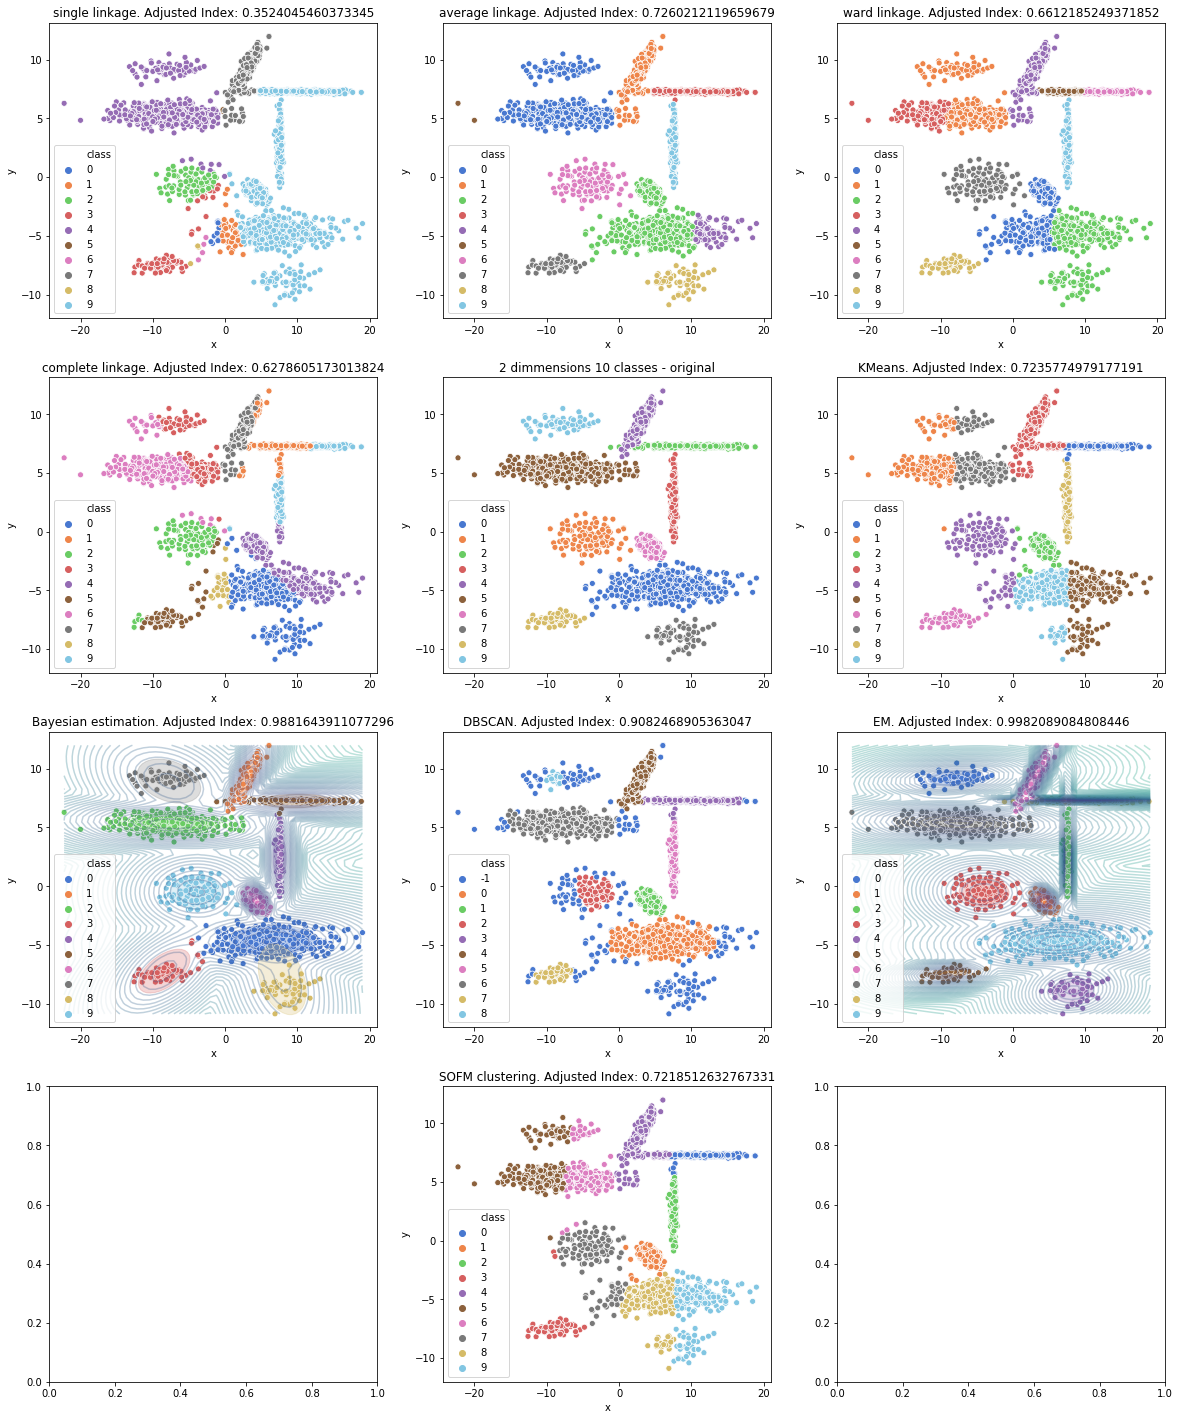

In [4]:
data = pd.read_csv('./data/2d-10c.dat', sep=' ', header=None)
data.columns = ['x','y','class']
number_of_classes = len(data['class'].unique())

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 25))
    
plot_clusters(data, axs[1][1])
axs[1][1].set_title("2 dimmensions 10 classes - original")

plot_hierarhical_cluster(data, 'single', number_of_classes, axs[0][0], 'cosine')
plot_hierarhical_cluster(data, 'average', number_of_classes, axs[0][1], 'manhattan')
plot_hierarhical_cluster(data, 'complete', number_of_classes, axs[1][0], 'cosine')
plot_hierarhical_cluster(data, 'ward', number_of_classes, axs[0][2])

plot_kmeans_cluster(data, number_of_classes, axs[1][2])

plot_dbscan_cluster(data, axs[2][1], 0.9, 15)
plot_estimation_maximization_cluster(data, axs[2][2], number_of_classes, covariance_type="full", n_init=10)
plot_bayesian_estimation_maximization_cluster(data, axs[2][0], number_of_classes, covariance_type="full", n_init=10)

plot_sofm_cluster(data, number_of_classes, axs[3][1])

### EM finds the best clusters because the data has separated clusters, with different shapes and number of points assigned to them. DBscan can explore the dense points in the feature space too but the different shapes and number of points in each cluster affects its overall performance. Even though kmeans and hierarhical clustering average have good adjusted index, we can observe that the centroids that they find are somehow in the middle of two original clusters
-------------

### Square

EM convergence:True
Bayesian estimation convergence:True


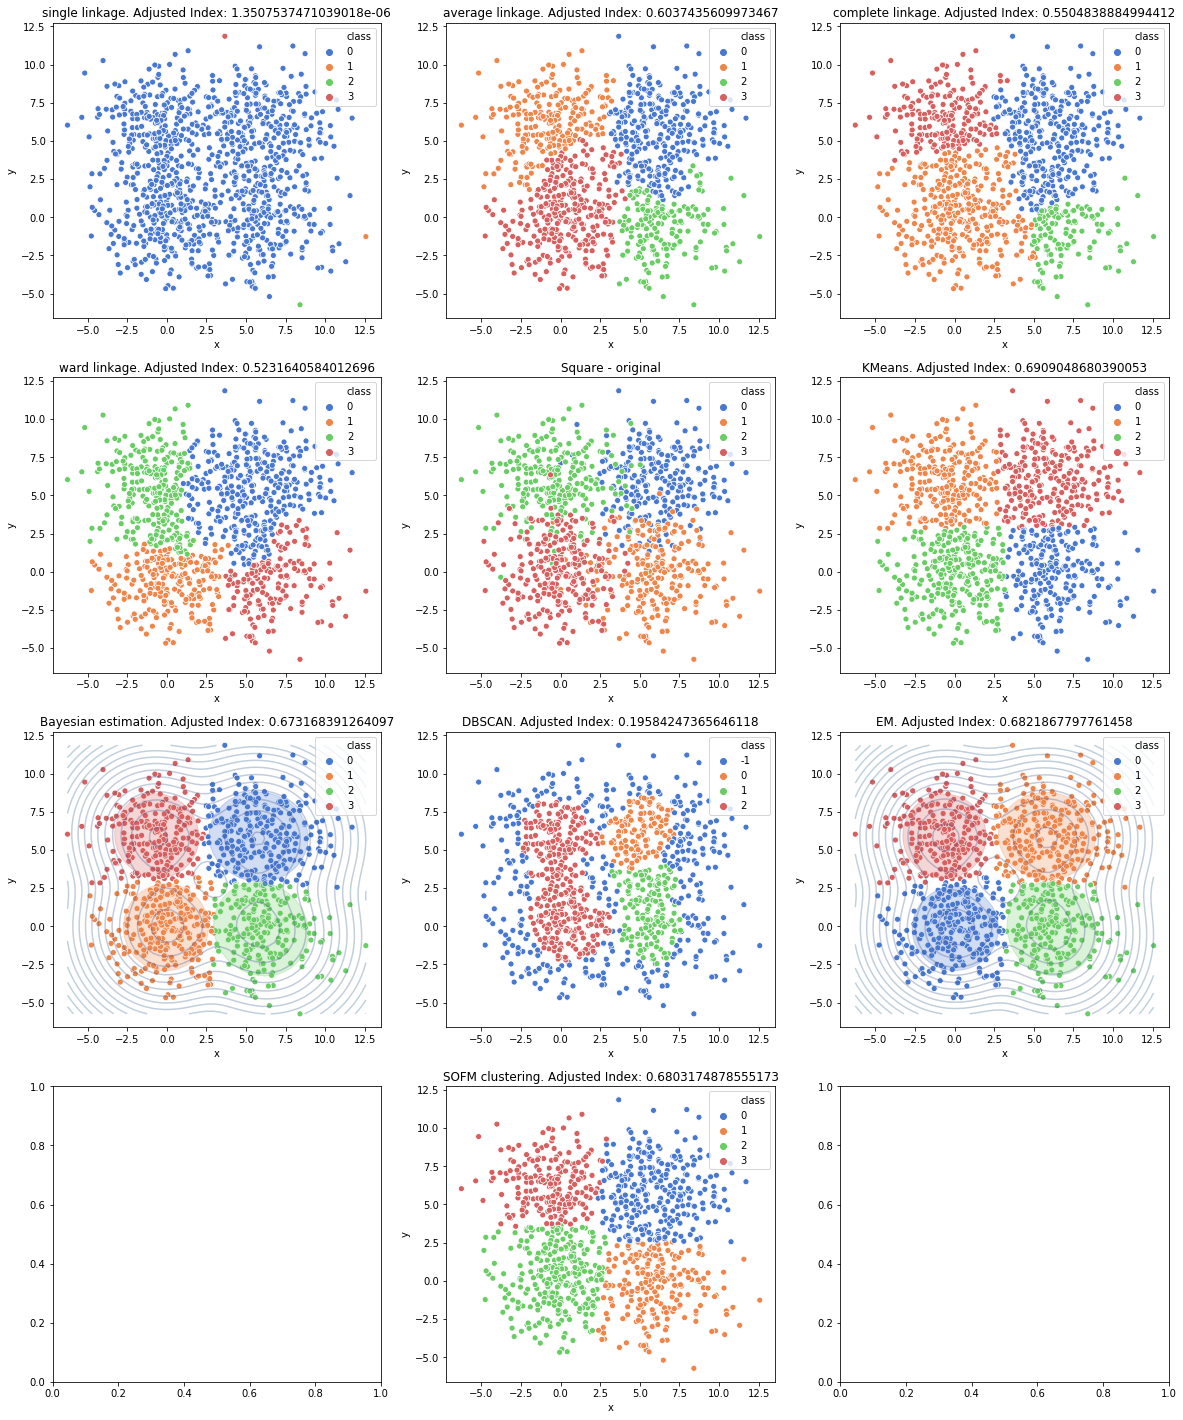

In [5]:
data = pd.read_csv('./data/square.data', sep=' ', header=None)
data.columns = ['x','y','class']
number_of_classes = len(data['class'].unique())

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 25))
    
plot_clusters(data, axs[1][1])
axs[1][1].set_title("Square - original")

plot_hierarhical_cluster(data, 'single', number_of_classes, axs[0][0])
plot_hierarhical_cluster(data, 'average', number_of_classes, axs[0][1])
plot_hierarhical_cluster(data, 'complete', number_of_classes, axs[0][2])
plot_hierarhical_cluster(data, 'ward', number_of_classes, axs[1][0])

plot_kmeans_cluster(data, number_of_classes, axs[1][2])

plot_dbscan_cluster(data, axs[2][1], 1.1, 30)
plot_estimation_maximization_cluster(data, axs[2][2], number_of_classes, covariance_type="full", n_init=10)
plot_bayesian_estimation_maximization_cluster(data, axs[2][0], number_of_classes, covariance_type="full", n_init=10)

plot_sofm_cluster(data, number_of_classes, axs[3][1])

### As expected, Kmeans does the best clustering here because the clusters have somehow a spherical shape. Average and complete linkage find close clustering too. EM should do well too but it has problems assigning points in the middle of the 4 clusters to any of them (overlapping clusters).
-------------

### Long

In [6]:
data = pd.read_csv('./data/long.data', sep=' ', header=None)
data.columns = ['x','y','class']
number_of_classes = len(data['class'].unique())

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 25))
    
plot_clusters(data, axs[1][1])
axs[1][1].set_title("Long - original")

plot_hierarhical_cluster(data, 'single', number_of_classes, axs[0][0])
plot_hierarhical_cluster(data, 'average', number_of_classes, axs[0][1])
plot_hierarhical_cluster(data, 'complete', number_of_classes, axs[0][2])
plot_hierarhical_cluster(data, 'ward', number_of_classes, axs[1][0])

plot_kmeans_cluster(data, number_of_classes, axs[1][2])
plot_kmeans_cluster(data, number_of_classes, axs[2][0], np.array([[0,5],[0,-5]]))

plot_dbscan_cluster(data, axs[2][1], 0.3, 3)
plot_estimation_maximization_cluster(data, axs[2][2], number_of_classes, covariance_type="full", n_init=100)
plot_bayesian_estimation_maximization_cluster(data, axs[2][0], number_of_classes, covariance_type="full", n_init=10)

plot_sofm_cluster(data, number_of_classes, axs[3][1])

EM convergence:True
Bayesian estimation convergence:True


### EM finds the right clusters because we have well separated clusters. DBScan does the same. We set the distance very close (0.3) and just 3 points as to min_sample parameter to keep clusters as dense as possible. If we 'help' KMeans by setting the initial clusters far apart of each other we oberved that because the original clusters have spherical form, the algorithm finds the right cluster distribution.
-------------

### 2 dimmensions 3 clusters

EM convergence:True
Bayesian estimation convergence:True


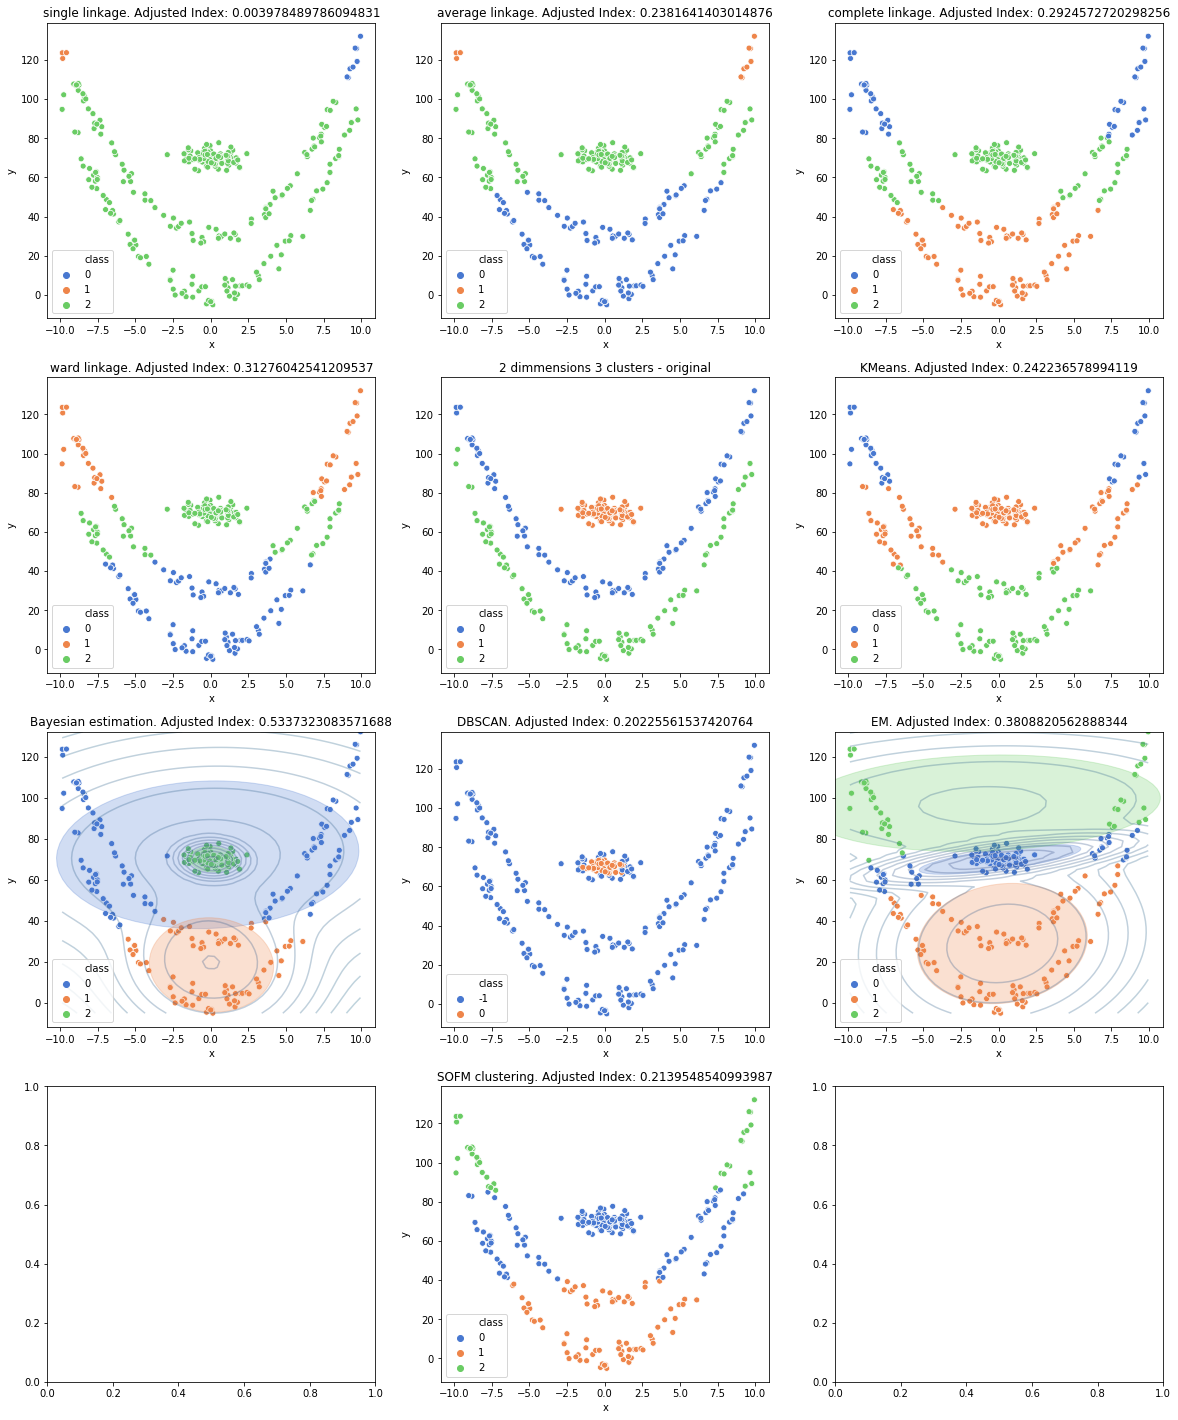

In [7]:
data = pd.read_csv('./data/order2-3clust.csv', sep=',', header=None)
data.columns = ['x','y','class']
number_of_classes = len(data['class'].unique())

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 25))
    
plot_clusters(data, axs[1][1])
axs[1][1].set_title("2 dimmensions 3 clusters - original")

plot_hierarhical_cluster(data, 'single', number_of_classes, axs[0][0])
plot_hierarhical_cluster(data, 'average', number_of_classes, axs[0][1], 'l1')
plot_hierarhical_cluster(data, 'complete', number_of_classes, axs[0][2])
plot_hierarhical_cluster(data, 'ward', number_of_classes, axs[1][0])

plot_kmeans_cluster(data, number_of_classes, axs[1][2])

plot_dbscan_cluster(data, axs[2][1], 0.8, 7)
plot_estimation_maximization_cluster(data, axs[2][2], number_of_classes, covariance_type="full", n_init=10)
plot_bayesian_estimation_maximization_cluster(data, axs[2][0], number_of_classes, covariance_type="full", n_init=10)

plot_sofm_cluster(data, number_of_classes, axs[3][1])

#### No algorithm finds the right shape of clusters. The data has overlapping clusters, with different shapes and has different number of points in each one of them.
-------------

### Iris

In [8]:
data = pd.read_csv('./data/iris.csv', sep=',', header=None)
data.columns = ['x','y','z','t', 'class']
number_of_classes = len(data['class'].unique())

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 25))
    
plot_clusters(data, axs[1][1])
axs[1][1].set_title("Iris - original")

plot_hierarhical_cluster(data, 'single', number_of_classes, axs[0][0])
plot_hierarhical_cluster(data, 'average', number_of_classes, axs[0][1])
plot_hierarhical_cluster(data, 'complete', number_of_classes, axs[0][2])
plot_hierarhical_cluster(data, 'ward', number_of_classes, axs[1][0])

plot_kmeans_cluster(data, number_of_classes, axs[1][2])

plot_dbscan_cluster(data, axs[2][1], 0.25, 5)
plot_estimation_maximization_cluster(data, axs[2][2], number_of_classes, covariance_type="full", n_init=10)
plot_bayesian_estimation_maximization_cluster(data, axs[2][0], number_of_classes, covariance_type="full", n_init=10)

plot_sofm_cluster(data, number_of_classes, axs[3][1])

EM convergence:True
Bayesian estimation convergence:True


### KMeans finds the best clustering because again the original clusters are in a spherical shape. What's interesting is that the bayesian estimation of gaussian distribution finds that the right number of clusters is 2. That's because the 2 overlapping clusters at the bottom have similar means and variances. With this clustering with 2 classes we obtain the same adjusted index as with a 3-cluster estimation maximisation algorithm
-------------